In [1]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import *

%matplotlib inline
np.random.seed(1)

/home/devendra/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Loading the dataset
X_train_orig , Y_train_orig , X_test_orig , Y_test_orig , classes = load_dataset()

y = 5


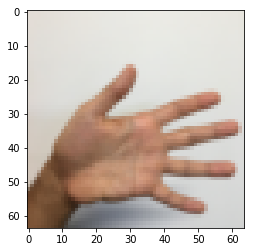

In [3]:
#checking proper import
index = 0 
plt.imshow(X_train_orig[index])
print("y = " + str(np.squeeze(Y_train_orig[:,index])))

In [4]:
#Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0],-1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0],-1).T

#Mormalize image vectors
X_train = X_train_flatten/255
X_test = X_test_flatten/255

#Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig,6)
Y_test = convert_to_one_hot(Y_test_orig,6)


In [5]:
#Checking the validity
print("number of training examples = " + str(X_train.shape[1]))
print("number of test examples = " + str(X_test.shape[1]))
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: "+str(Y_test.shape))

number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


## 1 - create placeholders

In [6]:
def create_placeholders(n_x,n_y):
    X = tf.placeholder(tf.float32,(n_x,None))
    Y = tf.placeholder(tf.float32,(n_y,None))
    return X , Y

In [7]:
X,Y = create_placeholders(12288,6)
print("X = "+str(X))
print("Y = "+str(Y))

X = Tensor("Placeholder:0", shape=(12288, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(6, ?), dtype=float32)


## 2 - Initializing the parameters

Initializes parameters to build a neural network with tensorflow. The shapes are:



                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    

In [8]:
def initialize_parameters():
    tf.set_random_seed(1)
    xavier_initializer = tf.contrib.layers.xavier_initializer(seed=1)
    zeros_initializer = tf.zeros_initializer()
    W1 = tf.get_variable("W1",[25,12288],initializer=xavier_initializer)
    b1 = tf.get_variable("b1",[25,1],initializer=zeros_initializer)
    
    W2 = tf.get_variable("W2",[12,25],initializer=xavier_initializer)
    b2 = tf.get_variable("b2",[12,1],initializer=zeros_initializer)
    
    W3 = tf.get_variable("W3",[6,12],initializer=xavier_initializer)
    b3 = tf.get_variable("b3",[6,1],initializer=zeros_initializer)
    
    parameters = {
        "W1":W1,
        "b1":b1,
        "W2":W2,
        "b2":b2,
        "W3":W3,
        "b3":b3
    }
    return parameters
    

In [9]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print("W3 = " + str(parameters["W3"]))
    print("b3 = " + str(parameters["b3"]))

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(6, 12) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(6, 1) dtype=float32_ref>


## 3 - Forward propagation in tensorfow

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation

In [10]:
def forward_propagation(X,parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    Z1 = tf.add(tf.matmul(W1,X),b1)
    A1 = tf.nn.relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1),b2)
    A2 = tf.nn.relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2),b3)
    
    return Z3

In [11]:
tf.reset_default_graph()
with tf.Session() as sess:
    X,Y = create_placeholders(12288,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X,parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("Add_2:0", shape=(6, ?), dtype=float32)


## 4 - Compute cost

- It is important to know that the "`logits`" and "`labels`" inputs of `tf.nn.softmax_cross_entropy_with_logits` are expected to be of shape (number of examples, num_classes). We have thus transposed Z3 and Y for you.
- Besides, `tf.reduce_mean` basically does the summation over the examples.

In [12]:
def compute_cost(Z3 , Y):
    logits = tf.transpose(Z3) #to fit tensorflow requirement
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    
    return cost

In [13]:
tf.reset_default_graph()
with tf.Session() as sess:
    X,Y = create_placeholders(12288,6)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X , parameters)
    cost = compute_cost(Z3 , Y)
    print("cost  = "+ str(cost))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

cost  = Tensor("Mean:0", shape=(), dtype=float32)


## 5 - Backward propagation and parameter updates

For instance, for gradient descent the optimizer would be:
```python
optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
```

To make the optimization you would do:
```python
_ , c = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
```

## 6 - Building the model

In [14]:
def model(X_train,Y_train,X_test,Y_test,learning_rate=0.0001,num_epochs=1500,minibatch_size=32,print_cost=True):
    
    ops.reset_default_graph()
    tf.set_random_seed(1)
    seed = 3
    (n_x,m) = X_train.shape
    n_y = Y_train.shape[0]
    costs=[]
    
    X,Y = create_placeholders(n_x,n_y)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X , parameters)
    cost = compute_cost(Z3,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0
            num_minibatches = int(m/minibatch_size)
            seed  = seed +1
            minibatches = random_mini_batches(X_train , Y_train , minibatch_size , seed)
            
            for minibatch in minibatches:
                (minibatch_X , minibatch_Y) = minibatch
                
                _,minibatch_cost = sess.run([optimizer,cost] , feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                epoch_cost += minibatch_cost/num_minibatches
            
            if print_cost and epoch %100 ==0:
                print("Cost after epoch %i:%f"%(epoch,epoch_cost))
            if print_cost and epoch % 5==0:
                costs.append(epoch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate = "+str(learning_rate))
        plt.show()
        
        parameters = sess.run(parameters)
        print("parameters have been trained!")
        
        correct_prediction = tf.equal(tf.argmax(Z3) , tf.argmax(Y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction , "float"))
        
        print("Train accuracy" , accuracy.eval({X:X_train , Y:Y_train}))
        print("Test accuracy" , accuracy.eval({X:X_test , Y:Y_test}))
        
        return parameters

Cost after epoch 0:1.855702
Cost after epoch 100:1.016411
Cost after epoch 200:0.733188
Cost after epoch 300:0.572921
Cost after epoch 400:0.468836
Cost after epoch 500:0.381291
Cost after epoch 600:0.313962
Cost after epoch 700:0.254535
Cost after epoch 800:0.203957
Cost after epoch 900:0.166740
Cost after epoch 1000:0.142372
Cost after epoch 1100:0.107723
Cost after epoch 1200:0.085986
Cost after epoch 1300:0.060894
Cost after epoch 1400:0.051012


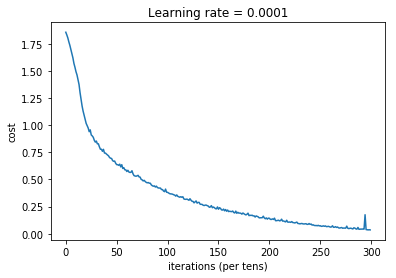

parameters have been trained!
Train accuracy 0.9990741
Test accuracy 0.725


In [15]:
parameters = model(X_train , Y_train , X_test ,Y_test)